In [ ]:
!pip install yfinance
!pip install pykalman

In [ ]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf

Pair to be traded = Walmart, Target Corporation

In [ ]:
adata = yf.download('WMT', start="2010-01-01", end="2014-12-31")
adata.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,WMT,WMT,WMT,WMT,WMT
Date,,,,,
2010-01-04,13.084427,13.190588,12.949311,12.966201,62259300
2010-01-05,12.954137,13.074775,12.925183,13.050647,46945200
2010-01-06,12.925179,12.987911,12.888989,12.908289,37551600
2010-01-07,12.932419,12.968611,12.850384,12.961373,31988100
2010-01-08,12.867276,12.915531,12.792480,12.891403,34089600


In [ ]:
bdata = yf.download('TGT', start="2010-01-01", end="2014-12-31")
bdata.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TGT,TGT,TGT,TGT,TGT
Date,,,,,
2010-01-04,32.633121,32.861654,32.532300,32.579350,4589100
2010-01-05,32.754101,33.090178,32.438187,32.606226,4760100
2010-01-06,33.379192,33.406079,32.659987,32.659987,7217400
2010-01-07,33.789200,34.138720,33.419515,33.742149,12531000
2010-01-08,33.654781,33.681668,33.325427,33.641338,6512800


Text(0, 0.5, 'Price')

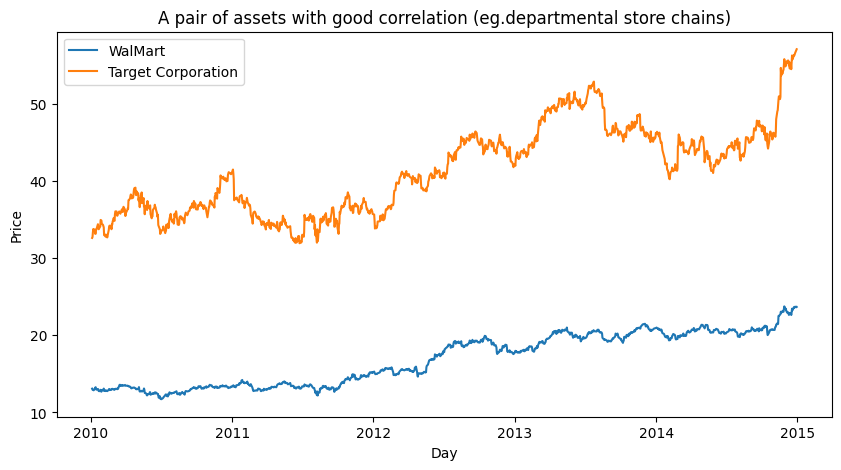

In [ ]:
plt.figure(figsize =(10,5))
plt.plot(adata['Close'])
plt.plot(bdata['Close'])
plt.title('A pair of assets with good correlation (eg.departmental store chains)')
plt.legend(['WalMart', 'Target Corporation'])
plt.xlabel('Day')
plt.ylabel('Price')

In [ ]:
y = adata['Close'].values
x = bdata['Close'].values
x_const = sm.add_constant(x)
linear_reg = sm.OLS(y,x_const)
results = linear_reg.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     5978.
Date:                Sat, 08 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:54:58   Log-Likelihood:                -2201.1
No. Observations:                1257   AIC:                             4406.
Df Residuals:                    1255   BIC:                             4416.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.1777      0.288    -17.974      0.000      -5.743      -4.613
x1             0.5335      0.007     77.316      0.000       0.520       0.547
==============================================================================
Omnibus:                       22.063   Durbin-Watson:                   0.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.819
Skew:                           0.254   Prob(JB):                     4.97e-05
Kurtosis:                       2.653   Cond. No.                         306.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<ipython-input-32-1445bb1b76f9>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels([str(p) for p in bdata.index])


[Text(1, 30.0, '2010-01-04 00:00:00'),
 Text(1, 35.0, '2010-01-05 00:00:00'),
 Text(1, 40.0, '2010-01-06 00:00:00'),
 Text(1, 45.0, '2010-01-07 00:00:00'),
 Text(1, 50.0, '2010-01-08 00:00:00'),
 Text(1, 55.0, '2010-01-11 00:00:00'),
 Text(1, 60.0, '2010-01-12 00:00:00')]

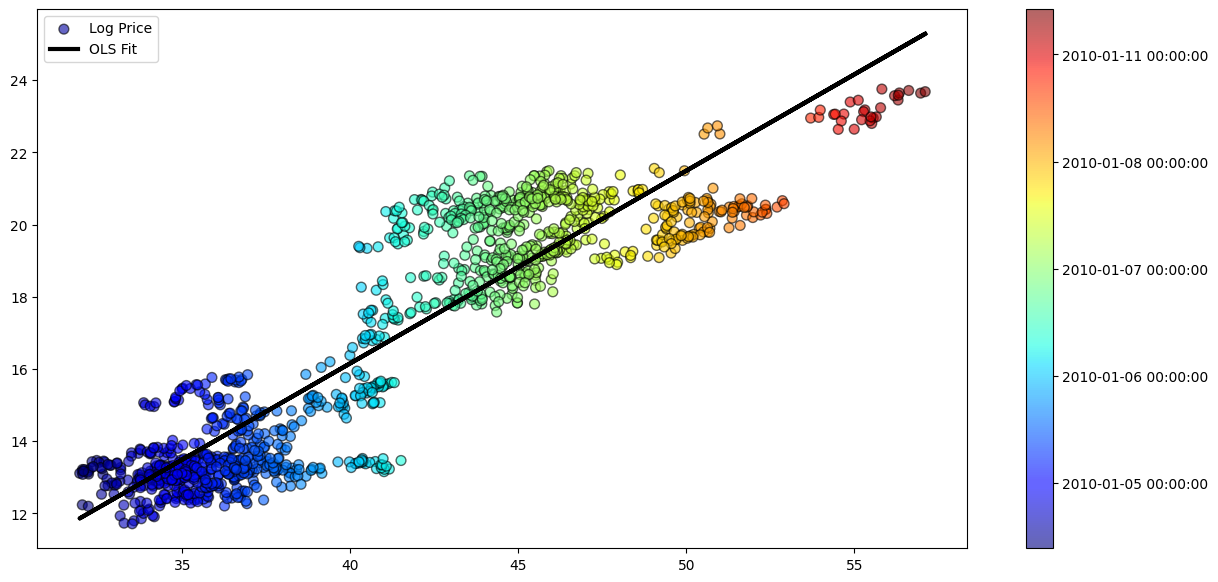

In [ ]:
beta = results.params[1]
alpha = results.params[0]
y_pred = bdata['Close'].values*beta + alpha
plt.figure(figsize =(15,7))
cm = plt.get_cmap('jet')
sc = plt.scatter(bdata['Close'].values, adata['Close'].values, s=50, c=x, cmap=cm, marker='o',
                 alpha=0.6,label='Log Price',edgecolor='k')
plt.plot(x, y_pred, '-',c='black',linewidth=3, label='OLS Fit')
plt.legend()
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p) for p in bdata.index])

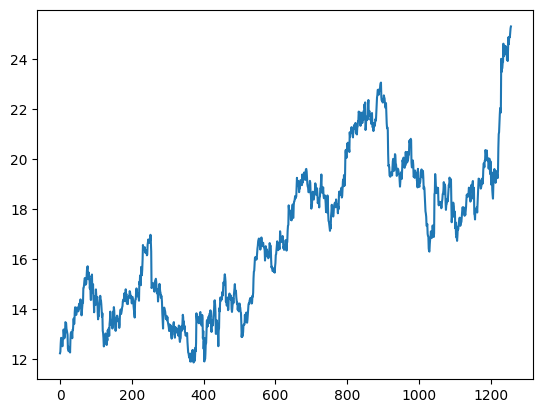

In [ ]:
plt.plot(y_pred)

Looks a little like the walmart's curve, doesn't it? however it is the underlying prediction, our strategy being Walmart's actual curve is supposed to revert back to it

Text(0, 0.5, 'Diversion')

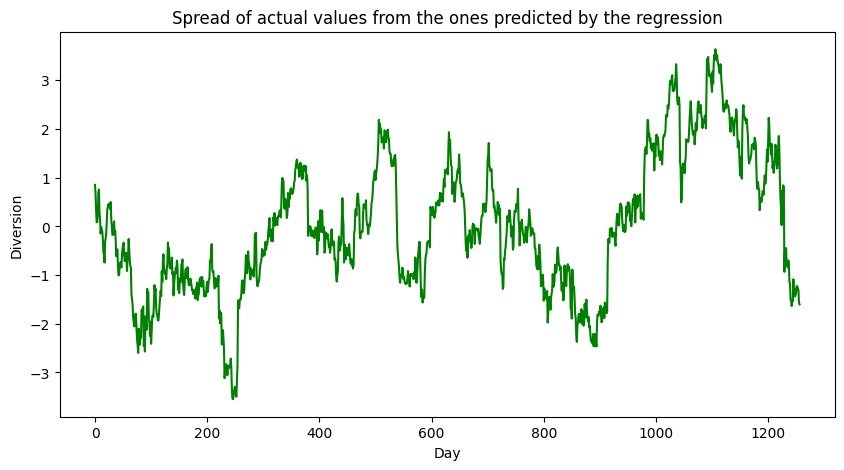

In [ ]:
reg_spread = adata['Close'].values - y_pred
plt.figure(figsize =(10,5))
plt.plot(reg_spread, 'green')
plt.title('Spread of actual values from the ones predicted by the regression')
plt.xlabel('Day')
plt.ylabel('Diversion')

Here the trading signals being the bet of reversion of prices to the predicted ones, therefore when the curve is above zero line, the trading signal is to be long on Walmart and be short on Target Corporation and vice versa when it goes below the zero line.

Now, deploying a kalman filter to estimate the hedge ratio and constantly keeping it updating in sync with newer measurements

In [ ]:
obs_mat = sm.add_constant(bdata['Close'].values, prepend=False)[:, np.newaxis]
kfpt = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                  initial_state_mean=np.ones(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=1,
                  transition_covariance=0.000001* np.eye(2))

state_means, _ = kfpt.filter(adata['Close'].values)
slope=state_means[:, 0]
intercept=state_means[:, 1]

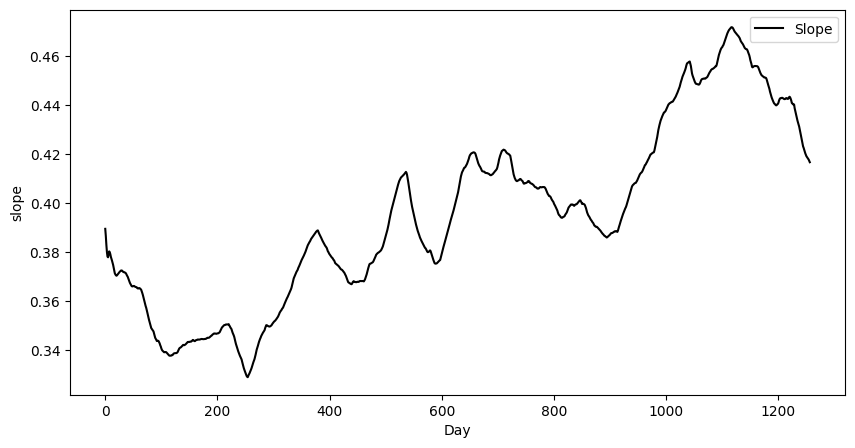

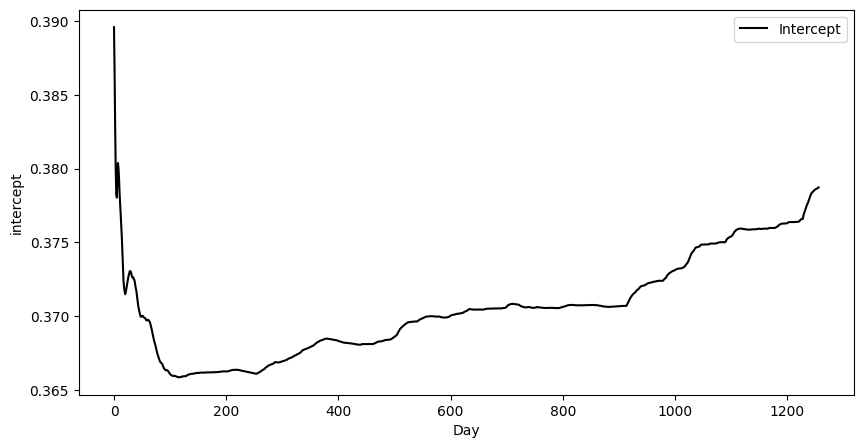

In [ ]:
plt.figure(figsize =(10,5))
plt.plot(slope, 'black')
plt.legend(['Slope'])
plt.ylabel('slope')
plt.xlabel('Day')

plt.figure(figsize =(10,5))

plt.plot(intercept, 'black')
plt.ylabel('intercept')
plt.xlabel('Day')

plt.legend(['Intercept'])


Text(0, 0.5, 'Diversion')

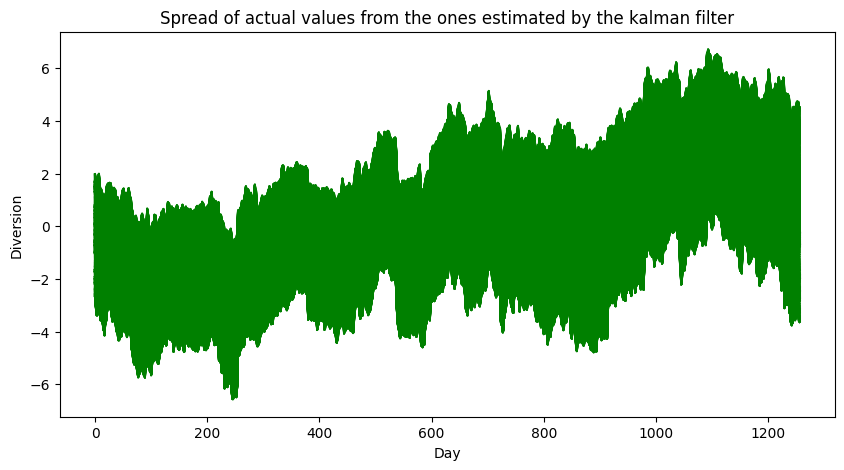

In [ ]:
kalman_filtered_spread = adata['Close'].values - bdata['Close'].values*slope - intercept
plt.figure(figsize =(10,5))
plt.plot(kalman_filtered_spread, 'green')
plt.title('Spread of actual values from the ones estimated by the kalman filter')
plt.xlabel('Day')
plt.ylabel('Diversion')

Text(0, 0.5, 'Diversion')

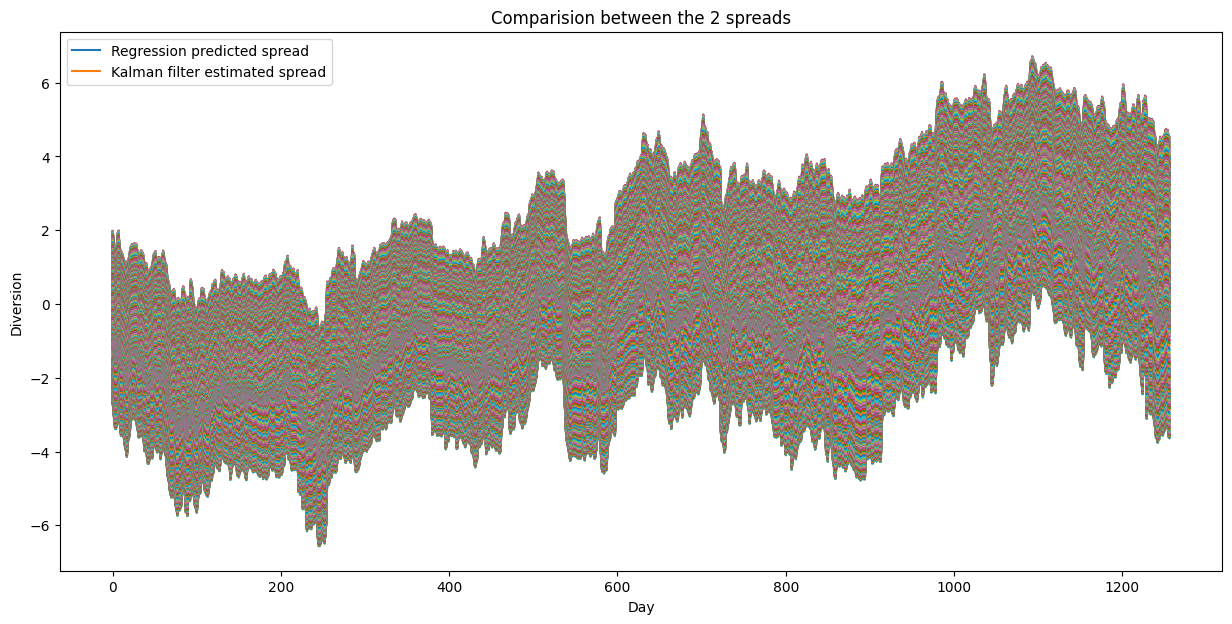

In [ ]:
plt.figure(figsize =(15,7))
plt.plot(reg_spread)
plt.plot(kalman_filtered_spread)
plt.title('Comparision between the 2 spreads')
plt.legend(['Regression predicted spread', 'Kalman filter estimated spread'])
plt.xlabel('Day')
plt.ylabel('Diversion')